In [182]:
# !jupyter nbconvert --to html hw2.ipynb
# !wkhtmltopdf hw2.html hw2.pdf

[NbConvertApp] Converting notebook hw2.ipynb to html
[NbConvertApp] Writing 1423989 bytes to hw2.html
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Loading page (1/2)
Printing pages (2/2)                                               
Done                                                           


# Imports

In [64]:
import numpy as np
import time
import random
import pickle

# Managing data

In [2]:
import os
folder = 'samples/'
def datasetIsHere(images_name):
    if not os.path.exists(folder + images_name):
        if not os.path.exists(folder):
            os.makedirs(folder)
        print("images not found, donwloading...")
        os.system("wget http://yann.lecun.com/exdb/mnist/%s.gz -O tmp.gz" % images_name)
        print("extracting...")
        os.system("gunzip tmp.gz && rm tmp.gz")
        os.system("mv tmp %s%s" % (folder, images_name))
        print("done")
        assert os.path.exists(folder + images_name)

In [3]:
dataset_names = [
    'train-images-idx3-ubyte',
    'train-labels-idx1-ubyte',
    't10k-images-idx3-ubyte',
    't10k-labels-idx1-ubyte'
]
for name in dataset_names:
    datasetIsHere(name)

In [4]:
from mnist import loader
mndata = loader.MNIST('samples')
X_train, y_train = mndata.load_training()
X_test, y_test = mndata.load_testing()

In [5]:
X_train = np.array(X_train).reshape((-1,1,28,28))
X_test = np.array(X_test).reshape((-1,1,28,28))
y_train = np.array(y_train)
y_test = np.array(y_test)

In [6]:
X_train.shape

(60000, 1, 28, 28)

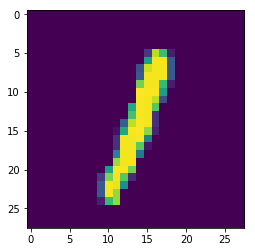

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_train[np.random.randint(len(X_train))][0])

# Calculate optimal $n$
Number of parameters in the suggested network 

conv3x3(n) -> conv3x3(n) -> max_pool -> conv3x3(1.5 n) -> conv3x3(1.5 n) -> max_pool -> conv3x3(2 n) ->  global_pool -> dense(10, nonlinearity = softmax)

1 (input) * 9 (size of filter) * n (output) + n * 9 * n + n * 9 * 1.5n + 1.5n * 9 * 2n + 2n * 10 (dense) + 10 (biases)

Wolfram says it is params(n) = 49.5n**2 + 29n + 10

Solving params(n) = 60000 yields 34.5

Round down to 32, for the sake of speed and a beautiful number.

# Long-long training
You can just skip the next 30 pages of training and go straight to the Drawing part.

In [8]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


In [9]:
class GlobalMaxPool(nn.Module):
        def forward(self, input):
            rez = torch.max(input.view(input.size(0), -1), dim=1)[0]
            rez = rez.reshape((-1,1))
            return rez
        
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    

def xavier_init(m):
    try:
        torch.nn.init.xavier_uniform(m.weight)
    except AttributeError:
        pass
    except ValueError:
        pass

In [10]:
# An auxilary function that returns mini-batches for neural network training
def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

In [54]:
from abc import abstractmethod
class TrainingContainer:
    def __init__(self, model, opt, batch_size=100, verbose=True):
        self._model = model
        self._opt = opt
        self._batch_size = batch_size
        self._training_loss = []
        self._validation_accuracy = []
        self._verbose = verbose
        self._epoch_loss = []
        self._epoch_acc = []
        self._X_val = None
        self._y_val = None

    @abstractmethod
    def compute_loss(self, X_batch, y_batch):
        pass

    @abstractmethod
    def batch_accuracy(self, X_batch, y_batch):
        pass

    @abstractmethod
    def append_loss(self, loss):
        pass

    def draw_graph(self):
        acc = self._epoch_acc
        loss = self._epoch_loss
        fig, ax1 = plt.subplots()
        ax1.plot(list(range(1, len(acc) + 1)), acc, color='b')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy', color='b')
        ax1.tick_params('y', colors='b')
        ax2 = ax1.twinx()
        ax2.plot(list(range(1, len(loss) + 1)), loss, color='r')
        ax2.set_ylabel('Loss', color='r')
        ax2.tick_params('y', colors='r')
        fig.tight_layout()
        plt.show()
    
    def train(self, X_train, y_train, iterable=range(0, 10), X_val=None, y_val=None):
        self._X_val = X_val
        self._y_val = y_val
        if self._X_val is None:
            self._X_val = X_train
            self._y_val = y_train
        for epoch in iterable:
            # In each epoch, we do a full pass over the training data:
            start_time = time.time()
            self._model.train(True)  # enable training mode
            for X_batch, y_batch in iterate_minibatches(X_train, y_train, self._batch_size):
                # train on batch
                loss = self.compute_loss(X_batch, y_batch)
                loss.backward()
                self._opt.step()
                self._opt.zero_grad()
                self.append_loss(loss)

            # And a full pass over the validation data:
            self._model.train(False)  # disable dropout / use averages for batch_norm
            for X_batch, y_batch in iterate_minibatches(self._X_val, self._y_val, self._batch_size):
                self._validation_accuracy.append(self.batch_accuracy(X_batch, y_batch))

            tl = np.mean(self._training_loss[-len(X_train) // self._batch_size:])
            self._epoch_loss.append(tl)
            va = np.mean(self._validation_accuracy[-len(self._X_val) // self._batch_size:]) * 100
            self._epoch_acc.append(va)

            if self._verbose:
                print("Epoch {} took {:.3f}s".format(
                    len(self._epoch_loss), time.time() - start_time))
                print("  training loss (in-iteration): \t{:.6f}".format(tl))
                print("  validation accuracy: \t\t\t{:.2f} %".format(va))


class CudaTrainingContainer(TrainingContainer):
    def compute_loss(self, X_batch, y_batch):
        X_batch = torch.FloatTensor(X_batch).cuda(self._device)
        y_batch = torch.LongTensor(y_batch).cuda(self._device)
        logits = self._model(X_batch)
        return F.cross_entropy(logits, y_batch).mean()

    def batch_accuracy(self, X_batch, y_batch):
        X_batch = torch.FloatTensor(X_batch).cuda(self._device)
        logits = self._model(X_batch).cpu()
        y_pred = logits.argmax(1).data.numpy()
        return np.mean(y_batch == y_pred)

    def append_loss(self, loss):
        self._training_loss.append(loss.cpu().data.numpy())

    def __init__(self, model, opt, batch_size=100, verbose=True, device=None):
        self._device = device
        super().__init__(model, opt, batch_size, verbose)
        model.cuda(self._device)
        model.apply(lambda t: t.cuda(device)) # somewhy it does not happen automatically with model.cuda()
#         print('Cuda in container called!!')
#         print(list(model.children()))


class CPUTrainingContainer(TrainingContainer):

    def compute_loss(self, X_batch, y_batch):
        X_batch = torch.FloatTensor(X_batch)
        y_batch = torch.LongTensor(y_batch)
        logits = self._model(X_batch)
        return F.cross_entropy(logits, y_batch).mean()


    def batch_accuracy(self, X_batch, y_batch):
        X_batch = torch.FloatTensor(X_batch)
        logits = self._model(X_batch)
        y_pred = logits.max(1)[1].data.numpy()
        return np.mean(y_batch == y_pred)

    def append_loss(self, loss):
        self._training_loss.append(loss.data.numpy())

    def __init__(self, model, opt, batch_size=100, verbose=True):
        model.cpu()
        super().__init__(model, opt, batch_size, verbose)



In [12]:
def construct_net(nonlinearity_factory, conv_factory, n=32):
    """
    creates a Sequential Module that corresponds to the benchmark architecture
    conv3x3(n) -> conv3x3(n) -> max_pool -> conv3x3(1.5 n) -> conv3x3(1.5 n) -> max_pool -> conv3x3(2 n) ->  global_pool -> dense(10, nonlinearity = softmax)
    :param n: well, the n from the formula
    """

    model = nn.Sequential()
    model.add_module('conv_n_0', conv_factory(1, n, kernel_size=(3, 3)))  # 26x26
    model.add_module('nonlinearity_n_0', nonlinearity_factory())
    model.add_module('conv_n_1', conv_factory(n, n, kernel_size=(3, 3)))  # 24x24
    model.add_module('nonlinearity_n_1', nonlinearity_factory())
    #     model.add_module('bn1', nn.BatchNorm2d(n)) # 24x24
    model.add_module('pool_n', nn.MaxPool2d(kernel_size=(2, 2)))  # 12x12

    m = int(1.5 * n)

    model.add_module('conv_1_5n_0', conv_factory(n, m, kernel_size=(3, 3)))  # 10x10
    model.add_module('nonlinearity_1_5n_0', nonlinearity_factory())
    model.add_module('conv_1_5n_1', conv_factory(m, m, kernel_size=(3, 3)))  # 8x8
    model.add_module('nonlinearity_1_5n_1', nonlinearity_factory())
    #     model.add_module('bn2', nn.BatchNorm2d(m)) # 24x24
    model.add_module('pool_1_5n', nn.MaxPool2d(kernel_size=(2, 2)))  # 4x4

    model.add_module('conv_2n_0', conv_factory(m, 2 * n, kernel_size=(3, 3)))  # 2x2
    model.add_module('nonlinearity_2n_0', nonlinearity_factory())
    #     model.add_module('bn3', nn.BatchNorm2d(2*n)) # 24x24
    model.add_module('pool_2n', nn.MaxPool2d(kernel_size=(2, 2)))  # 1x1

    #     model.add_module('global_pool', GlobalMaxPool())
    #     model.add_module('dense0', nn.Linear(1, 10))

    model.add_module('global_pool', Flatten())
    model.add_module('dense0', nn.Linear(2 * n, 10))
    #     model.add_module('dense2_logits', nn.Linear(100, 10)) # logits for 10 classes
    model.apply(xavier_init)

    opt = torch.optim.Adam(model.parameters(), betas=(0.9, 0.999), lr=1e-3)
    return model, opt

In [72]:

def create_k_mask(in_channels, out_channels, kernel, k):
    extended = kernel
    rez = torch.zeros((out_channels, in_channels, *kernel))
    # this is
    o = torch.ones(extended)
    lower = 0
    upper = k
    for i in range(0, out_channels):
        if lower < upper:
            rez[i, lower:upper, :, :] = o
        elif upper == 0:
            rez[i, lower:, :, :] = o
        else:
            rez[i, lower:, :, :] = o
            rez[i, 0:upper, :, :] = o
        lower = (lower + 1) % in_channels
        upper = (upper + 1) % in_channels
    return rez


def create_bernoilli_mask(in_channels, out_channels, kernel, p):
    extended = kernel
    rez = torch.zeros((out_channels, in_channels, *kernel))
    # this is
    o = torch.ones(extended)
    for i in range(0, out_channels):
        rez[i,random.randint(0,in_channels-1),:,:] = o
        for j in range(0, in_channels):
            if random.random() < p:
                rez[i,j,:,:] = o
    return rez


class MaskedConv2d(torch.nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, mask, stride=1, padding=0, dilation=1, groups=1, bias=True):
        super().__init__(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias)
        self._mask = mask

    def forward(self, input):
#         print(type(self._mask))
        return F.conv2d(input,
            self._mask * self.weight, # multiply weights by the mask before applying convolution
            self.bias, self.stride, self.padding, self.dilation, self.groups)
    
    def cuda(self, device=None):
        self._mask = self._mask.cuda(device)
#         print('cuda called!')
        return super(MaskedConv2d, self).cuda(device)
        
    def cpu(self):
        self._mask = self._mask.cpu()
        return super(MaskedConv2d, self).cpu()


class BlockedConv2d(MaskedConv2d):
    def __init__(self, in_channels, out_channels, kernel_size, k, stride=1, padding=0, dilation=1, groups=1, bias=True):
        """
        :param k: number of input channels that affect each output channel
        """
        assert k <= in_channels, "k is bigger than in_channels, the setting is equivalent to a full convolution"
        super().__init__(in_channels, out_channels, kernel_size,
             create_k_mask(in_channels, out_channels, kernel_size, k),
             stride, padding, dilation, groups, bias)


class BernoilliConv2d(MaskedConv2d):

    def __init__(self, in_channels, out_channels, kernel_size, p=0.1, stride=1, padding=0, dilation=1, groups=1, bias=True):
        """
        :param p: the probability that the pair (input_layer, output_layer) is connected
        """
        assert p > 0 and p < 1, "p should be a valid probability. Between 0 and 1"
        super().__init__(in_channels, out_channels, kernel_size,
             create_bernoilli_mask(in_channels, out_channels, kernel_size, p),
             stride, padding, dilation, groups, bias)


In [58]:
leaky_relu = lambda: nn.LeakyReLU(negative_slope=0.01)
def blocked_conv(in_channels, out_channels, kernel_size):
    k = 4
    if in_channels > k-1:
        return BlockedConv2d(in_channels, out_channels, kernel_size, k=k)
    else:
        return nn.Conv2d(in_channels, out_channels, kernel_size)
# simple_conv = lambda in_channels, out_channels, kernel_size: 
model, opt = construct_net(leaky_relu, blocked_conv, 32)
cont_blocked = CudaTrainingContainer(model, opt, 512)
cont_blocked.train(X_train, y_train, range(0, 50), X_test, y_test)

/home/nikita/python/envs/torch_cuda/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  


cuda called!
cuda called!
cuda called!
cuda called!
Epoch 1 took 9.902s
  training loss (in-iteration): 	0.724980
  validation accuracy: 			95.80 %
Epoch 2 took 9.748s
  training loss (in-iteration): 	0.131681
  validation accuracy: 			97.04 %
Epoch 3 took 9.742s
  training loss (in-iteration): 	0.093648
  validation accuracy: 			97.81 %
Epoch 4 took 9.689s
  training loss (in-iteration): 	0.073959
  validation accuracy: 			97.61 %
Epoch 5 took 9.721s
  training loss (in-iteration): 	0.066778
  validation accuracy: 			97.97 %
Epoch 6 took 9.739s
  training loss (in-iteration): 	0.054827
  validation accuracy: 			98.49 %
Epoch 7 took 9.754s
  training loss (in-iteration): 	0.049461
  validation accuracy: 			98.43 %
Epoch 8 took 9.815s
  training loss (in-iteration): 	0.045825
  validation accuracy: 			98.44 %
Epoch 9 took 9.722s
  training loss (in-iteration): 	0.043270
  validation accuracy: 			98.50 %
Epoch 10 took 9.723s
  training loss (in-iteration): 	0.040437
  validation accuracy

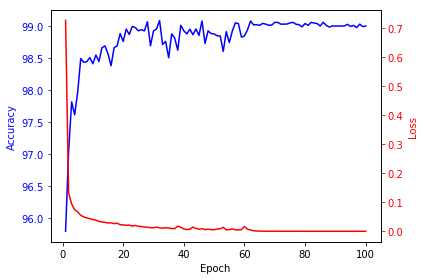

In [129]:
cont_blocked.draw_graph()

In [165]:
leaky_relu = lambda: nn.LeakyReLU(negative_slope=0.01)
def blocked_conv_14(in_channels, out_channels, kernel_size):
    k = 14
    if in_channels > k-1:
        return BlockedConv2d(in_channels, out_channels, kernel_size, k=k)
    else:
        return nn.Conv2d(in_channels, out_channels, kernel_size)
# simple_conv = lambda in_channels, out_channels, kernel_size: 
model, opt = construct_net(leaky_relu, blocked_conv_14, 32)
cont_blocked_14 = CudaTrainingContainer(model, opt, 512)
cont_blocked_14.train(X_train, y_train, range(0, 50), X_test, y_test)

/home/nikita/python/envs/torch_cuda/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  


Epoch 1 took 9.965s
  training loss (in-iteration): 	0.529528
  validation accuracy: 			96.32 %
Epoch 2 took 10.049s
  training loss (in-iteration): 	0.097636
  validation accuracy: 			96.28 %
Epoch 3 took 9.786s
  training loss (in-iteration): 	0.066244
  validation accuracy: 			97.74 %
Epoch 4 took 9.943s
  training loss (in-iteration): 	0.049075
  validation accuracy: 			98.33 %
Epoch 5 took 9.917s
  training loss (in-iteration): 	0.040764
  validation accuracy: 			98.55 %
Epoch 6 took 9.855s
  training loss (in-iteration): 	0.034940
  validation accuracy: 			98.89 %
Epoch 7 took 9.934s
  training loss (in-iteration): 	0.026171
  validation accuracy: 			98.82 %
Epoch 8 took 9.917s
  training loss (in-iteration): 	0.023211
  validation accuracy: 			98.93 %
Epoch 9 took 9.985s
  training loss (in-iteration): 	0.019387
  validation accuracy: 			98.83 %
Epoch 10 took 9.796s
  training loss (in-iteration): 	0.017439
  validation accuracy: 			98.78 %
Epoch 11 took 9.767s
  training loss (

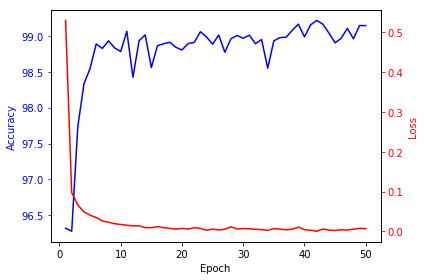

In [166]:
cont_blocked_14.draw_graph()

In [78]:
leaky_relu = lambda: nn.LeakyReLU(negative_slope=0.01)
simple_conv = lambda in_channels, out_channels, kernel_size: nn.Conv2d(in_channels, out_channels, kernel_size)
model, opt = construct_net(leaky_relu, simple_conv, 32)
cont_base = CudaTrainingContainer(model, opt, 512)

/home/nikita/python/envs/torch_cuda/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  


In [79]:
cont_base.train(X_train, y_train, range(0,50), X_test, y_test)

Epoch 1 took 9.675s
  training loss (in-iteration): 	1.149390
  validation accuracy: 			94.99 %
Epoch 2 took 9.648s
  training loss (in-iteration): 	0.126027
  validation accuracy: 			97.23 %
Epoch 3 took 9.649s
  training loss (in-iteration): 	0.077914
  validation accuracy: 			98.37 %
Epoch 4 took 9.696s
  training loss (in-iteration): 	0.056275
  validation accuracy: 			98.42 %
Epoch 5 took 9.698s
  training loss (in-iteration): 	0.041372
  validation accuracy: 			98.68 %
Epoch 6 took 9.688s
  training loss (in-iteration): 	0.033564
  validation accuracy: 			98.68 %
Epoch 7 took 9.699s
  training loss (in-iteration): 	0.028140
  validation accuracy: 			98.59 %
Epoch 8 took 9.765s
  training loss (in-iteration): 	0.024936
  validation accuracy: 			98.82 %
Epoch 9 took 9.910s
  training loss (in-iteration): 	0.021929
  validation accuracy: 			98.58 %
Epoch 10 took 9.892s
  training loss (in-iteration): 	0.016548
  validation accuracy: 			98.29 %
Epoch 11 took 9.739s
  training loss (i

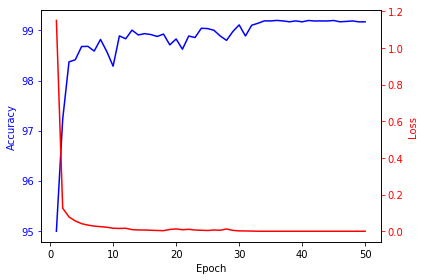

In [80]:
cont_base.draw_graph()

In [75]:
leaky_relu = lambda: nn.LeakyReLU(negative_slope=0.01)
bernoilli_conts = {}
for p in [0.1, 0.25, 0.5, 0.75]:
    def bernoilli_conv(in_channels, out_channels, kernel_size):
        return BernoilliConv2d(in_channels, out_channels, kernel_size, p=p)
    # simple_conv = lambda in_channels, out_channels, kernel_size: 
    model, opt = construct_net(leaky_relu, bernoilli_conv, 32)
    bernoilli_conts[p] = CudaTrainingContainer(model, opt, 512)
    bernoilli_conts[p].train(X_train, y_train, range(0, 50), X_test, y_test)

/home/nikita/python/envs/torch_cuda/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  


Epoch 1 took 9.721s
  training loss (in-iteration): 	0.612904
  validation accuracy: 			96.05 %
Epoch 2 took 9.656s
  training loss (in-iteration): 	0.116520
  validation accuracy: 			97.27 %
Epoch 3 took 9.655s
  training loss (in-iteration): 	0.082622
  validation accuracy: 			97.94 %
Epoch 4 took 9.690s
  training loss (in-iteration): 	0.065545
  validation accuracy: 			98.09 %
Epoch 5 took 9.686s
  training loss (in-iteration): 	0.053493
  validation accuracy: 			98.56 %
Epoch 6 took 9.693s
  training loss (in-iteration): 	0.049252
  validation accuracy: 			98.35 %
Epoch 7 took 9.730s
  training loss (in-iteration): 	0.040948
  validation accuracy: 			98.56 %
Epoch 8 took 9.699s
  training loss (in-iteration): 	0.038561
  validation accuracy: 			98.57 %
Epoch 9 took 9.716s
  training loss (in-iteration): 	0.035023
  validation accuracy: 			98.84 %
Epoch 10 took 9.678s
  training loss (in-iteration): 	0.030222
  validation accuracy: 			98.61 %
Epoch 11 took 9.667s
  training loss (i

Epoch 36 took 9.748s
  training loss (in-iteration): 	0.000039
  validation accuracy: 			99.24 %
Epoch 37 took 9.888s
  training loss (in-iteration): 	0.000034
  validation accuracy: 			99.29 %
Epoch 38 took 9.738s
  training loss (in-iteration): 	0.000030
  validation accuracy: 			99.22 %
Epoch 39 took 9.892s
  training loss (in-iteration): 	0.000027
  validation accuracy: 			99.23 %
Epoch 40 took 9.752s
  training loss (in-iteration): 	0.000024
  validation accuracy: 			99.25 %
Epoch 41 took 9.967s
  training loss (in-iteration): 	0.000022
  validation accuracy: 			99.27 %
Epoch 42 took 9.779s
  training loss (in-iteration): 	0.000020
  validation accuracy: 			99.27 %
Epoch 43 took 9.928s
  training loss (in-iteration): 	0.000018
  validation accuracy: 			99.24 %
Epoch 44 took 9.870s
  training loss (in-iteration): 	0.000017
  validation accuracy: 			99.25 %
Epoch 45 took 9.886s
  training loss (in-iteration): 	0.000015
  validation accuracy: 			99.23 %
Epoch 46 took 9.905s
  trainin

Epoch 21 took 10.401s
  training loss (in-iteration): 	0.005020
  validation accuracy: 			99.20 %
Epoch 22 took 10.475s
  training loss (in-iteration): 	0.003458
  validation accuracy: 			99.02 %
Epoch 23 took 10.690s
  training loss (in-iteration): 	0.002901
  validation accuracy: 			99.02 %
Epoch 24 took 10.959s
  training loss (in-iteration): 	0.003491
  validation accuracy: 			99.12 %
Epoch 25 took 12.039s
  training loss (in-iteration): 	0.003139
  validation accuracy: 			99.02 %
Epoch 26 took 11.767s
  training loss (in-iteration): 	0.015336
  validation accuracy: 			98.86 %
Epoch 27 took 10.968s
  training loss (in-iteration): 	0.005342
  validation accuracy: 			99.14 %
Epoch 28 took 10.397s
  training loss (in-iteration): 	0.003609
  validation accuracy: 			99.05 %
Epoch 29 took 10.143s
  training loss (in-iteration): 	0.004992
  validation accuracy: 			99.12 %
Epoch 30 took 10.081s
  training loss (in-iteration): 	0.005557
  validation accuracy: 			99.05 %
Epoch 31 took 10.169

p=0.1


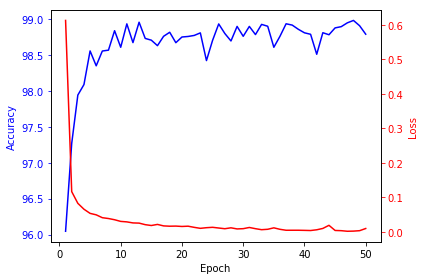

p=0.25


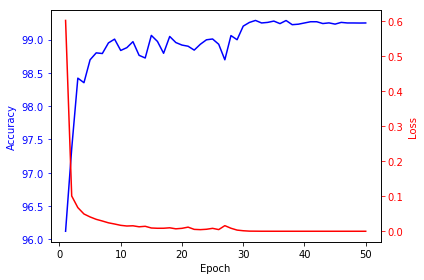

p=0.5


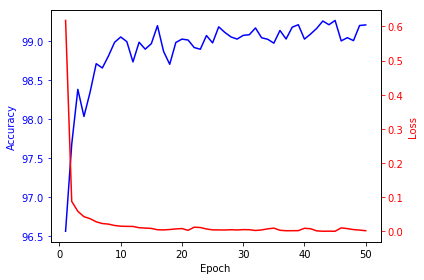

p=0.75


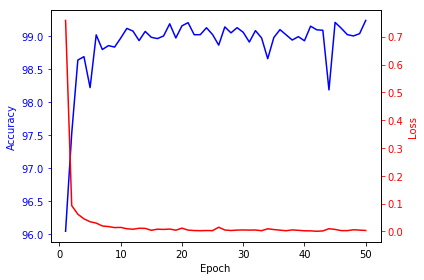

In [77]:
for p, cont in bernoilli_conts.items():
    print("p={}".format(p))
    cont.draw_graph()

In [81]:
nonlin_sigm = lambda: nn.Sigmoid()
simple_conv = lambda in_channels, out_channels, kernel_size: nn.Conv2d(in_channels, out_channels, kernel_size)
model, opt = construct_net(nonlin_sigm, simple_conv, 32)
cont_sigm = CudaTrainingContainer(model, opt, 512)

/home/nikita/python/envs/torch_cuda/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  


In [82]:
cont_sigm.train(X_train, y_train, range(0, 50), X_test, y_test)

Epoch 1 took 9.908s
  training loss (in-iteration): 	1.930458
  validation accuracy: 			83.43 %
Epoch 2 took 9.982s
  training loss (in-iteration): 	0.530682
  validation accuracy: 			94.21 %
Epoch 3 took 10.054s
  training loss (in-iteration): 	0.249728
  validation accuracy: 			96.39 %
Epoch 4 took 10.001s
  training loss (in-iteration): 	0.165284
  validation accuracy: 			97.37 %
Epoch 5 took 9.957s
  training loss (in-iteration): 	0.126218
  validation accuracy: 			97.81 %
Epoch 6 took 9.910s
  training loss (in-iteration): 	0.103717
  validation accuracy: 			98.07 %
Epoch 7 took 9.939s
  training loss (in-iteration): 	0.086792
  validation accuracy: 			98.28 %
Epoch 8 took 9.938s
  training loss (in-iteration): 	0.078092
  validation accuracy: 			98.30 %
Epoch 9 took 9.915s
  training loss (in-iteration): 	0.067845
  validation accuracy: 			98.48 %
Epoch 10 took 10.219s
  training loss (in-iteration): 	0.063532
  validation accuracy: 			98.55 %
Epoch 11 took 10.026s
  training los

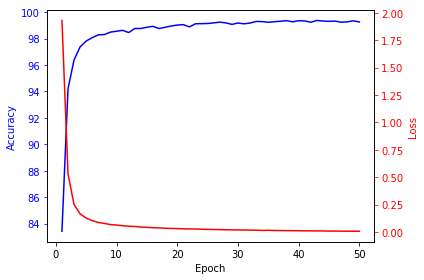

In [85]:
cont_sigm.draw_graph()

In [83]:
nonlin_elu = lambda: nn.ELU()
simple_conv = lambda in_channels, out_channels, kernel_size: nn.Conv2d(in_channels, out_channels, kernel_size)
model, opt = construct_net(nonlin_elu, simple_conv, 32)
cont_elu = CudaTrainingContainer(model, opt, 512)

/home/nikita/python/envs/torch_cuda/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  


In [84]:
cont_elu.train(X_train, y_train, range(0, 50), X_test, y_test)

Epoch 1 took 9.872s
  training loss (in-iteration): 	0.962900
  validation accuracy: 			96.64 %
Epoch 2 took 9.985s
  training loss (in-iteration): 	0.090548
  validation accuracy: 			97.91 %
Epoch 3 took 10.073s
  training loss (in-iteration): 	0.054840
  validation accuracy: 			98.12 %
Epoch 4 took 9.908s
  training loss (in-iteration): 	0.037804
  validation accuracy: 			98.53 %
Epoch 5 took 9.844s
  training loss (in-iteration): 	0.028291
  validation accuracy: 			98.80 %
Epoch 6 took 9.858s
  training loss (in-iteration): 	0.020943
  validation accuracy: 			98.65 %
Epoch 7 took 9.884s
  training loss (in-iteration): 	0.015430
  validation accuracy: 			98.75 %
Epoch 8 took 9.854s
  training loss (in-iteration): 	0.013340
  validation accuracy: 			98.78 %
Epoch 9 took 9.993s
  training loss (in-iteration): 	0.011390
  validation accuracy: 			98.80 %
Epoch 10 took 9.815s
  training loss (in-iteration): 	0.006690
  validation accuracy: 			99.01 %
Epoch 11 took 9.783s
  training loss (

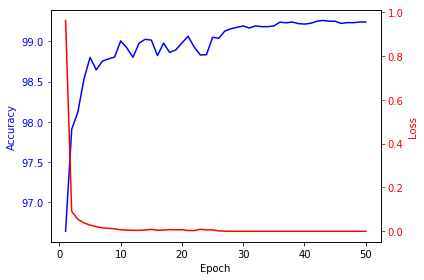

In [86]:
cont_elu.draw_graph()

In [171]:
all_conts = {'bern_'+str(p): cont for p, cont in bernoilli_conts.items()}
all_conts['base'] = cont_base
all_conts['sigm'] = cont_sigm
all_conts['elu'] = cont_elu
all_conts['blocked_4'] = cont_blocked
all_conts['blocked_14'] = cont_blocked_14

bern_0.1


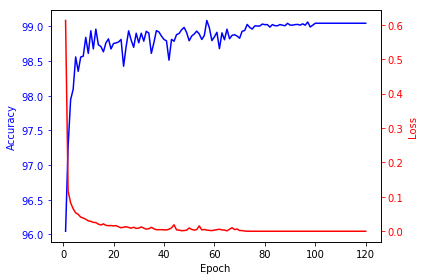

bern_0.25


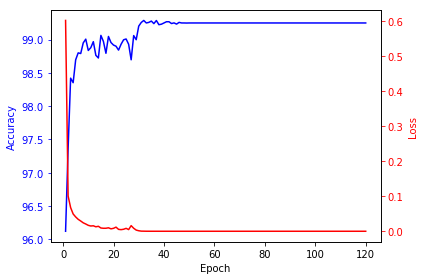

bern_0.5


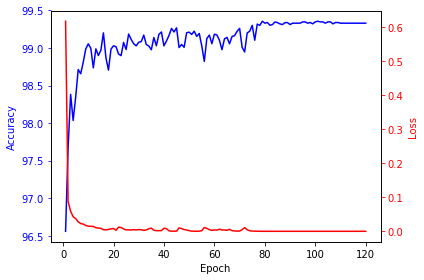

bern_0.75


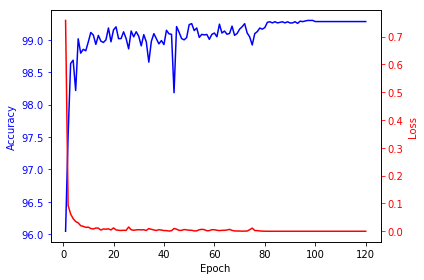

base


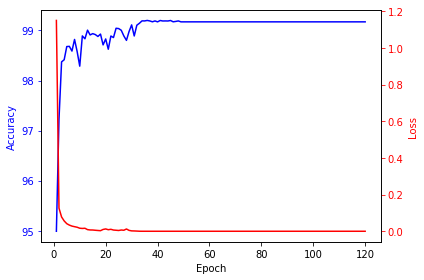

sigm


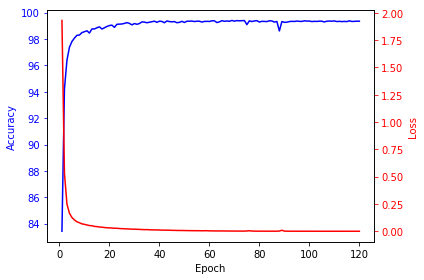

elu


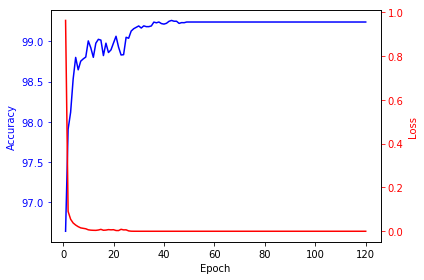

blocked_4


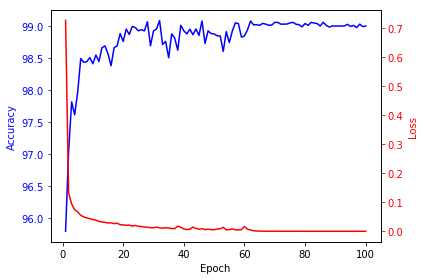

blocked_14


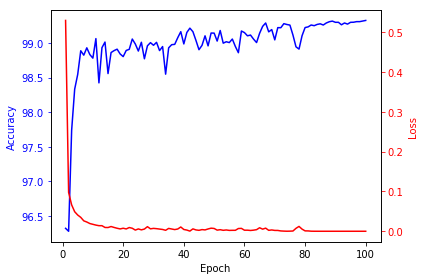

In [172]:
scores_dict = {}
for name, cont in all_conts.items():
    print(name)
    cont.draw_graph()
    scores_dict[name] = (cont._epoch_loss, cont._epoch_acc)
with open('conts.pkl', 'wb') as fl:
    pickle.dump(scores_dict, fl)

In [105]:
def train_more(cont, steps=10):
    cont.train(X_train, y_train, range(0, steps), X_test, y_test)
    cont.draw_graph()

Epoch 81 took 9.939s
  training loss (in-iteration): 	0.000837
  validation accuracy: 			99.23 %
Epoch 82 took 9.827s
  training loss (in-iteration): 	0.000167
  validation accuracy: 			99.26 %
Epoch 83 took 9.765s
  training loss (in-iteration): 	0.000034
  validation accuracy: 			99.25 %
Epoch 84 took 9.888s
  training loss (in-iteration): 	0.000012
  validation accuracy: 			99.27 %
Epoch 85 took 9.864s
  training loss (in-iteration): 	0.000009
  validation accuracy: 			99.28 %
Epoch 86 took 9.953s
  training loss (in-iteration): 	0.000008
  validation accuracy: 			99.26 %
Epoch 87 took 9.845s
  training loss (in-iteration): 	0.000007
  validation accuracy: 			99.29 %
Epoch 88 took 9.927s
  training loss (in-iteration): 	0.000006
  validation accuracy: 			99.31 %
Epoch 89 took 9.858s
  training loss (in-iteration): 	0.000006
  validation accuracy: 			99.32 %
Epoch 90 took 9.968s
  training loss (in-iteration): 	0.000005
  validation accuracy: 			99.30 %
Epoch 91 took 10.132s
  traini

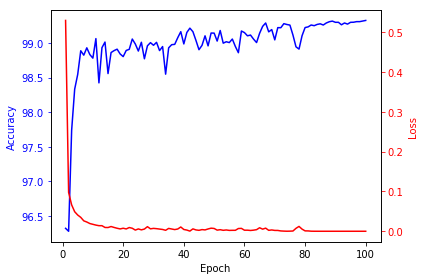

In [170]:
train_more(all_conts['blocked_14'], 20)

Epoch 81 took 9.727s
  training loss (in-iteration): 	0.000018
  validation accuracy: 			99.03 %
Epoch 82 took 9.709s
  training loss (in-iteration): 	0.000016
  validation accuracy: 			98.99 %
Epoch 83 took 9.712s
  training loss (in-iteration): 	0.000015
  validation accuracy: 			99.03 %
Epoch 84 took 9.787s
  training loss (in-iteration): 	0.000014
  validation accuracy: 			99.01 %
Epoch 85 took 9.801s
  training loss (in-iteration): 	0.000013
  validation accuracy: 			99.01 %
Epoch 86 took 9.891s
  training loss (in-iteration): 	0.000012
  validation accuracy: 			99.03 %
Epoch 87 took 9.808s
  training loss (in-iteration): 	0.000012
  validation accuracy: 			99.02 %
Epoch 88 took 9.765s
  training loss (in-iteration): 	0.000011
  validation accuracy: 			99.01 %
Epoch 89 took 9.777s
  training loss (in-iteration): 	0.000010
  validation accuracy: 			99.04 %
Epoch 90 took 9.788s
  training loss (in-iteration): 	0.000010
  validation accuracy: 			99.02 %
Epoch 91 took 9.770s
  trainin

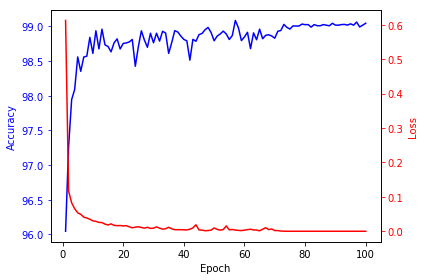

In [108]:
train_more(all_conts['bern_0.1'], 20)

Epoch 91 took 9.916s
  training loss (in-iteration): 	0.000002
  validation accuracy: 			99.33 %
Epoch 92 took 9.735s
  training loss (in-iteration): 	0.000002
  validation accuracy: 			99.33 %
Epoch 93 took 9.654s
  training loss (in-iteration): 	0.000002
  validation accuracy: 			99.33 %
Epoch 94 took 9.710s
  training loss (in-iteration): 	0.000001
  validation accuracy: 			99.33 %
Epoch 95 took 9.706s
  training loss (in-iteration): 	0.000001
  validation accuracy: 			99.35 %
Epoch 96 took 9.692s
  training loss (in-iteration): 	0.000001
  validation accuracy: 			99.35 %
Epoch 97 took 9.714s
  training loss (in-iteration): 	0.000001
  validation accuracy: 			99.33 %
Epoch 98 took 9.772s
  training loss (in-iteration): 	0.000001
  validation accuracy: 			99.34 %
Epoch 99 took 9.822s
  training loss (in-iteration): 	0.000001
  validation accuracy: 			99.32 %
Epoch 100 took 9.791s
  training loss (in-iteration): 	0.000001
  validation accuracy: 			99.35 %
Epoch 101 took 9.770s
  train

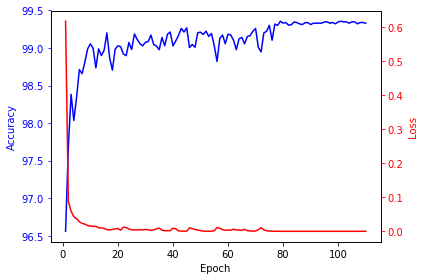

In [121]:
train_more(all_conts['bern_0.5'], 20)

Epoch 81 took 9.679s
  training loss (in-iteration): 	0.000032
  validation accuracy: 			99.27 %
Epoch 82 took 9.669s
  training loss (in-iteration): 	0.000007
  validation accuracy: 			99.28 %
Epoch 83 took 9.703s
  training loss (in-iteration): 	0.000005
  validation accuracy: 			99.26 %
Epoch 84 took 9.732s
  training loss (in-iteration): 	0.000004
  validation accuracy: 			99.28 %
Epoch 85 took 9.742s
  training loss (in-iteration): 	0.000003
  validation accuracy: 			99.26 %
Epoch 86 took 10.208s
  training loss (in-iteration): 	0.000003
  validation accuracy: 			99.27 %
Epoch 87 took 9.765s
  training loss (in-iteration): 	0.000003
  validation accuracy: 			99.28 %
Epoch 88 took 9.762s
  training loss (in-iteration): 	0.000002
  validation accuracy: 			99.26 %
Epoch 89 took 9.790s
  training loss (in-iteration): 	0.000002
  validation accuracy: 			99.28 %
Epoch 90 took 9.764s
  training loss (in-iteration): 	0.000002
  validation accuracy: 			99.26 %
Epoch 91 took 9.754s
  traini

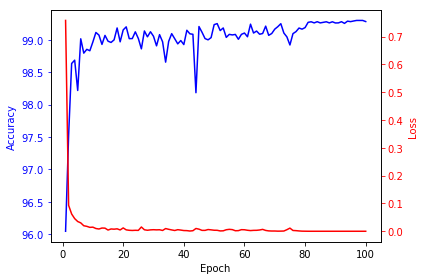

In [113]:
train_more(all_conts['bern_0.75'], 20)

Epoch 81 took 9.706s
  training loss (in-iteration): 	0.000036
  validation accuracy: 			99.01 %
Epoch 82 took 9.637s
  training loss (in-iteration): 	0.000033
  validation accuracy: 			99.05 %
Epoch 83 took 9.686s
  training loss (in-iteration): 	0.000031
  validation accuracy: 			99.04 %
Epoch 84 took 9.669s
  training loss (in-iteration): 	0.000029
  validation accuracy: 			99.03 %
Epoch 85 took 9.697s
  training loss (in-iteration): 	0.000028
  validation accuracy: 			99.00 %
Epoch 86 took 9.705s
  training loss (in-iteration): 	0.000026
  validation accuracy: 			99.05 %
Epoch 87 took 9.689s
  training loss (in-iteration): 	0.000024
  validation accuracy: 			99.01 %
Epoch 88 took 9.721s
  training loss (in-iteration): 	0.000023
  validation accuracy: 			98.98 %
Epoch 89 took 9.702s
  training loss (in-iteration): 	0.000022
  validation accuracy: 			99.00 %
Epoch 90 took 9.730s
  training loss (in-iteration): 	0.000020
  validation accuracy: 			99.00 %
Epoch 91 took 9.728s
  trainin

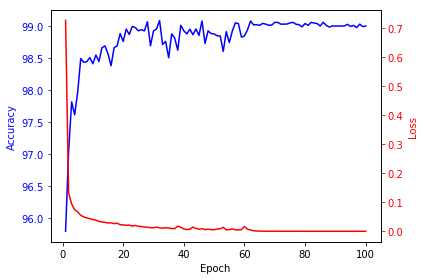

In [116]:
train_more(all_conts['blocked'], 20)

Epoch 101 took 9.729s
  training loss (in-iteration): 	0.000377
  validation accuracy: 			99.32 %
Epoch 102 took 9.719s
  training loss (in-iteration): 	0.000370
  validation accuracy: 			99.34 %
Epoch 103 took 9.759s
  training loss (in-iteration): 	0.000342
  validation accuracy: 			99.33 %
Epoch 104 took 9.772s
  training loss (in-iteration): 	0.000326
  validation accuracy: 			99.35 %
Epoch 105 took 9.767s
  training loss (in-iteration): 	0.000304
  validation accuracy: 			99.35 %
Epoch 106 took 9.753s
  training loss (in-iteration): 	0.000298
  validation accuracy: 			99.29 %
Epoch 107 took 9.753s
  training loss (in-iteration): 	0.000293
  validation accuracy: 			99.35 %
Epoch 108 took 9.769s
  training loss (in-iteration): 	0.000279
  validation accuracy: 			99.36 %
Epoch 109 took 9.772s
  training loss (in-iteration): 	0.000254
  validation accuracy: 			99.35 %
Epoch 110 took 9.816s
  training loss (in-iteration): 	0.000249
  validation accuracy: 			99.37 %
Epoch 111 took 9.794

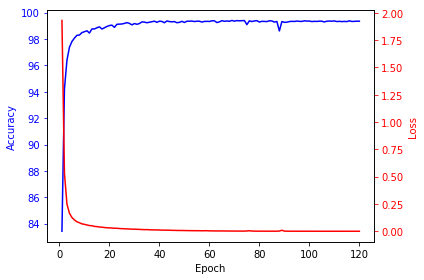

In [120]:
train_more(all_conts['sigm'], 20)

In [131]:
scores_dict.keys()

dict_keys(['bern_0.1', 'bern_0.25', 'bern_0.5', 'bern_0.75', 'base', 'sigm', 'elu', 'blocked'])

In [164]:
def draw_one_graph(ys, names, lims):
    fig, ax = plt.subplots()
    for y, name in zip(ys, names):
        ax.plot(y, label=name)
    legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
    ax.set_ylim(lims)
    plt.show()

def pad_last(lists, new_len):
    for lst in lists:
        if len(lst) >= new_len:
            continue
        lst += [lst[-1]] * (new_len - len(lst))
    return lists
    
def compare_group(scores, keys):
    aligned_acc = [scores[key][1] for key in keys]
    aligned_loss = [scores[key][0] for key in keys]
    common_len = max([len(lst) for lst in aligned_acc])
    aligned_acc, aligned_loss = pad_last(aligned_acc, common_len), pad_last(aligned_loss, common_len)
    arr1 = np.array(aligned_acc)
    arr2 = np.array(aligned_loss)
#     draw_one_graph(aligned_acc, keys, (np.quantile(arr1, 0.1), np.max(arr1) + 0.1))
    draw_one_graph(aligned_acc, keys, (98.0, 100.0))
#     draw_one_graph(aligned_loss, keys, (0.0, np.quantile(arr2, 0.9)))
    draw_one_graph(aligned_loss, keys, (0.0, 0.03))


# Drawing
Let us compare qualities of different networks. The learning was performed as follows:
- train for 50 epochs
- look at the learning curve
- if the loss is still big enough, train another 10-20-30 epochs, look again
- stop when the loss is somewhere around 1e-4

Testing data was not used to stop training, nor to train the network. Testing data was only used to plot the accuracy against epoch. One could also use only one value of accuracy on testing after the stopping condition was met, but the plot is more visual. 

compare_group function takes the list of names of network modifications and plots two graphs: the upper one shows accuracy on the _testing_ dataset against the number of epochs passed, the lower one shows the training loss against the number of epochs passed.
Different networks could have been trained for different number of epochs before convergence. All the scores were padded with the last value to become of the same length. This is the reason why some curves end with a plateau. This is nothing more than padding.

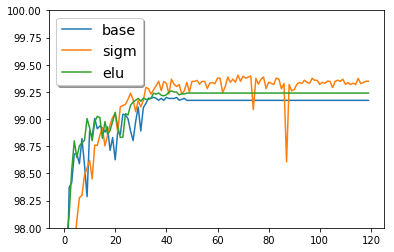

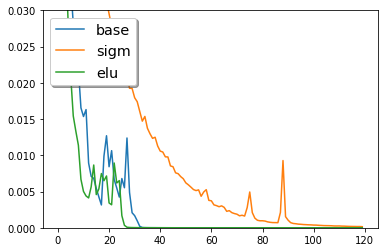

In [161]:
compare_group(scores_dict, ['base', 'sigm','elu'])

The plots comparing networks with ordinary convolutions, but different nonlinearities.
Sigmoid took the longest time to converge. If fact, 120 epochs is the biggest number of epochs needed among all modifications of the network considered. At the same time, Sigmoid was able to get the highest accuracy on the test dataset. Even though the training error was slow to converge for Sigmoid, the accuracy converged as fast as for the rest of nonlinearities. Seems like Sigmoid has the smallest ability to adopt for the data and the highest ability to generalize.

Elu and LeakyRelu have almost identical learnng curves, but Elu is a little bit more accurate than baseline.

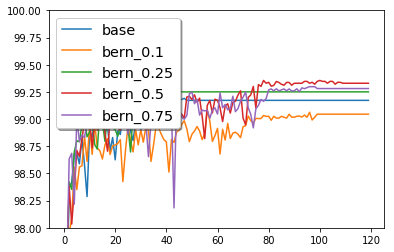

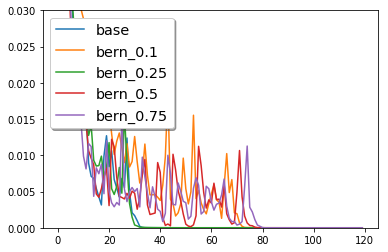

In [162]:
compare_group(scores_dict, ['base', 'bern_0.1','bern_0.25', 'bern_0.5', 'bern_0.75'])

The plots above compare the baseline with different Bernoilli connected convolutional networks.

One can notice that the baseline is beat by almost all modifications apart from $p=0.1$. I believe $p=0.1$ does not have enough power to learn the true dependency, since each output layer is connected to only about 3-4 input layers. It effectively decreases the number of parameters ten times.

Bernoilli_0.25 and the baseline both converged in the first 50 epochs, while the others after about 80.

Bernoilli_0.75 is really close to the baseline. No wonder. $ p=0.75 $ means that most of the layers are connected.

Bernoilli_0.5 was the modification that obtained the highest accuracy in this group. It has enough parameters to fit the data, but not too much to overfit.

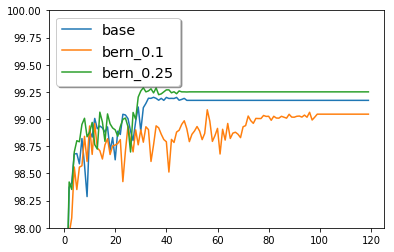

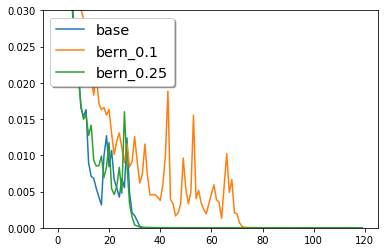

In [173]:
compare_group(scores_dict, ['base', 'bern_0.1','bern_0.25'])

Selected two modifications vs baseline to make it easier to llok at the graph.

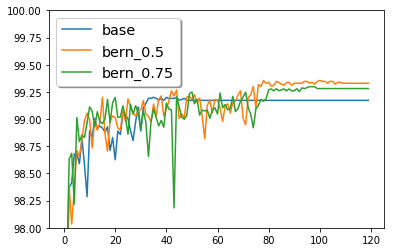

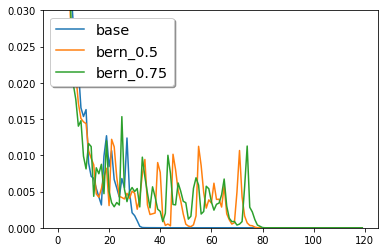

In [174]:
compare_group(scores_dict, ['base', 'bern_0.5', 'bern_0.75'])

The same: selected two modifications vs baseline to make it easier to llok at the graph.

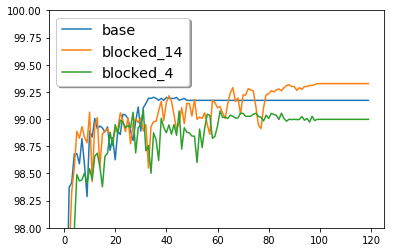

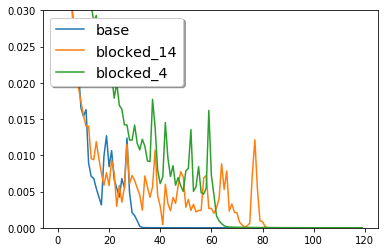

In [177]:
compare_group(scores_dict, ['base', 'blocked_14', 'blocked_4'])

Compared a blocked convolution with two different sizes of block (4 and 14) to the baseline.

The one with 4 is worse than the baseline. I believe that the reason is the same as for Bernoilli_0.1 - not enough parameters. Look at the comparison between Bernoilli_0.1 and blocked_4 below. Both: the learning curves and the accuracy are really close. Bernoilli_0.1 is a little bit better.

Blocked_14 is better than the baseline and converges slower. I think that it is due to smaller ability to overfit. The situation is close to Bernoilli_0.5, the number of parameters is roughly the same, too. Look at the comparison between Bernoilli_0.5 and blocked_14 on the plot with the best results.

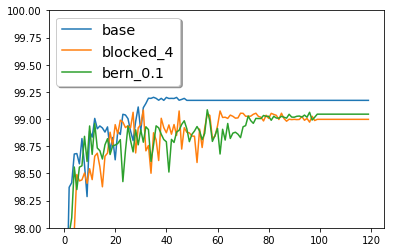

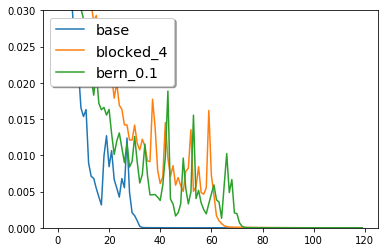

In [180]:
compare_group(scores_dict, ['base', 'blocked_4', 'bern_0.1'])

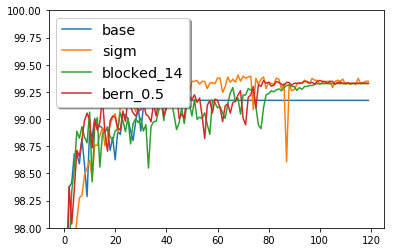

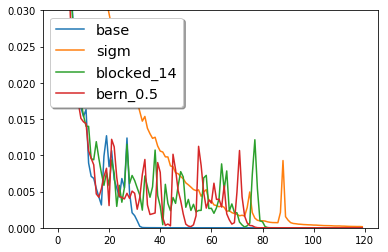

In [179]:
compare_group(scores_dict, ['base', 'sigm', 'blocked_14', 'bern_0.5'])

The plot above contains the baseline as well as the best modifications of each kind. I.e. the best nonlinearity, the best Blocked convolution and the best Bernoilli.

Surprisingly enough, Sigmoid nonlinearity has the same accuracy result as Blocked_14 and Bernoilli_0.5. I have already discussed the similarity of the latter ones. It seems that the only reason for a better testing accuracy is the fact that modifications are a bit more restricted (all but Sigmoid) and are less prone to overfit.